<a href="https://colab.research.google.com/github/TimilsinaSushil/Thesis/blob/DNN/DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch==1.3.1+cpu -f https://download.pytorch.org/whl/torch_stable.html
!pip install inltk
!pip install nepali-stemmer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached https://download.pytorch.org/whl/cpu/torch-1.3.1%2Bcpu-cp37-cp37m-linux_x86_64.whl (111.8 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0
    Uninstalling torch-1.11.0:
      Successfully uninstalled torch-1.11.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.3.1+cpu which is incompatible.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.3.1+cpu which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.3.1+cpu which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Us

In [ ]:
from inltk.inltk import setup
from inltk.inltk import tokenize
from inltk.inltk import get_embedding_vectors
from nepali_stemmer.stemmer import NepStemmer
# setup('ne')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('QSN.csv')

Saving QSN.csv to QSN.csv


['temporal' 'location' 'numerical' 'person' 'organization' 'explanation' 'miscellaneous']


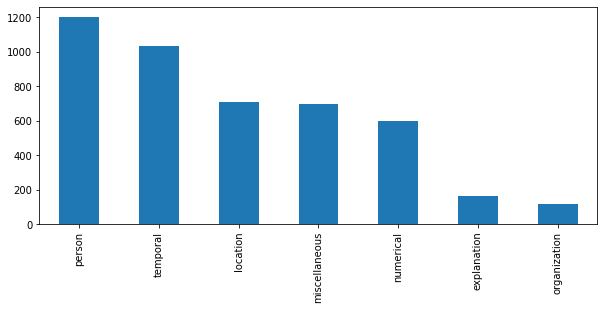

In [ ]:
#coarse type filtering
df=df[df['CoarseType'].isin(['location','temporal','numerical','person','organization','explanation','miscellaneous'])]
coarse_type=df['CoarseType'].unique()
print(coarse_type)
plt.figure(figsize=(10,4))
df.CoarseType.value_counts().plot(kind='bar');


**Text Preprocessig**

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#removing text inside brackets and quotes
import re
def removeTextInsideQuotesAndBrackets(text):
  text=re.sub("[\(\[].*?[\)\]]", "", text)
  text=re.sub("\'.*?\'","",text)
  text=re.sub('\".*?\"',"",text)
  return text

In [ ]:
def removeKo(text):
  words= text.split()
  text=[]
  for word in words:
    length=len(word)
    if(length > 2):
      if(word[-2]=='क' and word[-1]=='ो'):
        if(word!='कसको'):
          word= word[:length-2]
    text.append(word)
  text=' '.join([word for word in text])
  # print(text)
  return text




In [ ]:
def preprocessing(questions):
  questions=questions.apply(removeTextInsideQuotesAndBrackets)
  questions = questions.apply(removeKo)
  #tokenization
  questions= questions.apply(lambda x: tokenize(x,'ne'))
  #removing duplicates
  questions= questions.apply(lambda x: list(dict.fromkeys(x)))
  
  questions=questions.apply(lambda x: ' '.join(x).replace('▁','').split())
  questions=questions.apply(lambda x: ' '.join(x))

  #removing numbers
  questios=questions.apply(lambda x: ''.join(c for c in x if not c.isdigit()))
  #removing punctuation
  punctuation=['!','"','#','$','&',"'",'(',')','*','+',',','-','.','/',':',';','<','=','>','?','@','[',"]",'^','_','`','{','|','}','~']
  questions = questions.apply(lambda x: ''.join(c for c in x if c not in punctuation))

  #removing stopwords
  WHWORDS = ['कुन','कहिले','के','कति','को','कसले','कहाँ','कसलाई','कसको','कस्तो','कति','कसरी','किन','कता']
  STOPWORDS = stopwords.words('nepali')
  # Removig WH words from STOPWORDS
  for word in WHWORDS:
    if word in STOPWORDS: STOPWORDS.remove(word)

  STOPWORDS=set(STOPWORDS)
  def clean_text(text):
      text=' '.join([word for word in text.split() if word not in STOPWORDS]) # delete stopwords from text
      return text
  questions = questions.apply(clean_text)
  return questions



In [ ]:
#stemmig
# nepstem = NepStemmer()
# df['Questions'] = df['Questions'].apply(nepstem.stem)
# df.head(10)

In [ ]:
df['Questions'] = preprocessing(df['Questions'])

dataset=df

df.head()

,Questions,Answer,CoarseType,FineType,WhWord,Domain
0,नेपाली क्रिकेट टिम क्याप्टेन ज्ञानेन्द्र मल्ल ...,वि.सं. २०७६ कार्तिक १३,temporal,date,कहिले,Sports
1,फ्रान्स लियोन सम्पन्न महिला विश्वकप फुटबल २०१९...,अमेरिका,location,country,कसले,Sports
2,विश्व शान्ति सू चा ंक २०१९ नेपाल कति औ स्थानमा...,७६ औ स्थानमा,numerical,rank,कति,Miscellaneous
3,फलफूल बोट रु दश नोट कार्यक्रम सुरुवात कुन जिल्...,"इच्छाकामना गाउँपालिका, चितवन",location,city,कुन,Politics
4,माथिल्लो त्रिशुली थ्री जल विध ुत आयोजना विधुत ...,वि.स. २०७६ जेठ ०२,temporal,date,कहिले,Miscellaneous


*The topology of a neural network that classifies text is somewhat different than that of the networks presented thus far. It still has a dense layer (or layers), and it still has a sigmoid output layer with one neuron for binary classification or a softmax output layer with one neuron per class for multiclass classification. But preceding those layers are an embedding layer and a flatten layer. The former uses word embeddings to transform arrays, or sequences, of scalar values representing words into arrays of word vectors, which encode information about relationships between words. The latter “flattens” the 2D arrays output by the embedding layer into 1D arrays that can be input to a dense layer.*

In [ ]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Questions'])
sequences = tokenizer.texts_to_sequences(df['Questions'])
# print(sequences)

*Neural network expects all sequences to be the same length. Keras’s pad_sequences function performs this final step, truncating sequences longer than the specified length and padding sequences shorter than the specified length with 0s:*

In [ ]:
from keras.preprocessing.sequence import pad_sequences
padded_sequences = pad_sequences(sequences, maxlen=100)
print(padded_sequences)

[[   0    0    0    0 ... 1101  104    3  227]
 [   0    0    0    0 ...   56    7   63  201]
 [   0    0    0    0 ...    4  414  148   26]
 [   0    0    0    0 ...    1   72  237  958]
 ...
 [   0    0    0    0 ... 2085 3368   13  252]
 [   0    0    0    0 ...    4  355 3367  246]
 [   0    0    0    0 ...  528  144 1141   36]
 [   0    0    0    0 ...  528  144 1141   36]]


*The first hidden layer in a neural network that classifies text is an embedding layer whose job is to convert padded sequences of word indices into arrays of word vectors, which represent each word with an array of floating-point numbers rather than a single integer. Each word in the input text is represented by a vector in the embedding layer, and as the network is trained, vectors representing individual words are adjusted to reflect their relationship to one another. If you’re building a sentiment-analysis model and words such as “excellent” and “amazing” are generally associated with positive sentiment, then the vectors representing those words in the embedding space should be relatively close together so phrases such as “excellent service” and “amazing service” score similarly*

**One hot encoding of labels**

In [ ]:
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
le = preprocessing.LabelEncoder()
y=df.CoarseType;
print(y.unique())
y = le.fit_transform(y)
y = to_categorical(y) 

['temporal' 'location' 'numerical' 'person' 'organization' 'explanation' 'miscellaneous']


**Coarse Grained Classification**

TRAIN: [   0    1    3    4 ... 2254 2255 2256 2257] VALIDATION: [   2    5   16   24 ... 2239 2240 2244 2251]
Epoch 1/5
83/83 [==============================] - 2s 13ms/step - loss: 1.5831 - categorical_accuracy: 0.4607 - val_loss: 1.0197 - val_categorical_accuracy: 0.7854
Epoch 2/5
83/83 [==============================] - 1s 11ms/step - loss: 0.6239 - categorical_accuracy: 0.8256 - val_loss: 0.5192 - val_categorical_accuracy: 0.8252
Epoch 3/5
83/83 [==============================] - 1s 11ms/step - loss: 0.2512 - categorical_accuracy: 0.9275 - val_loss: 0.4551 - val_categorical_accuracy: 0.8496
Epoch 4/5
83/83 [==============================] - 1s 11ms/step - loss: 0.1005 - categorical_accuracy: 0.9817 - val_loss: 0.4422 - val_categorical_accuracy: 0.8717
Epoch 5/5
83/83 [==============================] - 1s 11ms/step - loss: 0.0460 - categorical_accuracy: 0.9934 - val_loss: 0.4478 - val_categorical_accuracy: 0.8673
TRAIN: [   0    2    3    4 ... 2252 2253 2255 2257] VALIDATION: [   

Text(48.49999999999999, 0.5, 'Actual label')

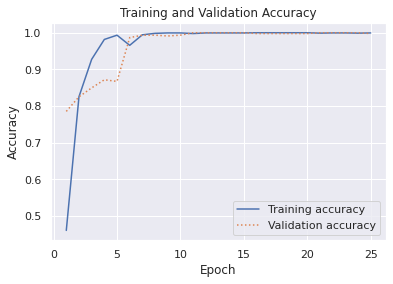

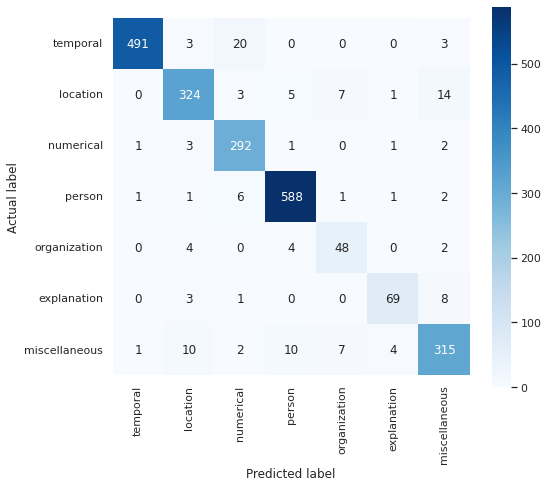

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

test_size=0.5
k_fold=5

epochs=5
learning_rate= 0.002
batch_size=22



x=padded_sequences;
x_train, x_test, y_train, y_test = train_test_split(x, y,stratify=y,test_size=test_size) 
acc = []
val = []
skf= StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=1)
# x=np.array(x_train)
# y=np.array(y_train)


# from keras.optimizers import Adam
model = Sequential() 
model.add(Embedding(10000, 32, input_length=100)) 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(7, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy']) 
#default value of learning rate will be 0.001
#adam is a variant of SGD(Sochastic gradient descent). Learning rate should be between (0.0001 to 0.1).Objective: Minimize the loss between actual output and predicted output.
model.optimizer.lr=learning_rate
# model.summary()

# K fold cross validation
for train_index, validation_index in skf.split(x_train, y_train.argmax(1)):
    print("TRAIN:", train_index, "VALIDATION:", validation_index)
    x_train, x_validation = x[train_index], x[validation_index]
    y_train, y_validation = y[train_index], y[validation_index]
    hist = model.fit(x_train, y_train, validation_data=(x_validation,y_validation), epochs=epochs, batch_size=batch_size)
    acc.extend(hist.history['categorical_accuracy']);
    val.extend(hist.history['val_categorical_accuracy'])


epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()


y_pred = model.predict(x_test)

test_accuracy = accuracy_score(y_pred.argmax(axis=1), y_test.argmax(axis=1))
print('Test Accuracy : %s' % test_accuracy)
# print(y_pred.argmax(axis=1))
# print(y_test.argmax(axis=1))
labels=y.argmax(axis=1)
labels=le.inverse_transform(labels)
labels=np.unique(labels)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1),target_names=labels))

mat = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1),labels=le.fit_transform(df.CoarseType.unique()))
import seaborn as sns
plt.figure(figsize=(8,7))
sns.set()
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap='Blues',xticklabels=df.CoarseType.unique(), yticklabels=df.CoarseType.unique())
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')




**Fine Grained Classification Model**

In [ ]:
def dnnFineGrained(coarse_type,fine_types,epoch,learning_rate,batch_size,test_size,k_fold):
  #decleration
  from keras.models import Sequential
  from keras.layers import Dense, Flatten
  from keras.layers.embeddings import Embedding
  from sklearn.model_selection import train_test_split
  output_shape=len(fine_types)
  # print(output_shape);
  subset=dataset[dataset['CoarseType']==coarse_type]
  subsetFineTypes=subset['FineType'].unique()
  # print(subsetFineTypes)
  subset= subset[subset['FineType'].isin(fine_types)]
  print(len(subset))



  from keras.preprocessing.text import Tokenizer
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(subset['Questions'])
  sequences = tokenizer.texts_to_sequences(subset['Questions'])


  from keras.preprocessing.sequence import pad_sequences
  padded_sequences = pad_sequences(sequences, maxlen=100)
  x=padded_sequences


  from sklearn import preprocessing
  from tensorflow.keras.utils import to_categorical
  le = preprocessing.LabelEncoder()
  y=subset.FineType
  y = le.fit_transform(y)
  y = to_categorical(y) 

  #train-test splitting
  x_train, x_test, y_train, y_test = train_test_split(x, y,stratify=y,test_size=test_size) 
  acc = []
  val = []
  skf= StratifiedKFold(n_splits=k_fold, shuffle=False, random_state=None)

  #Model
  model = Sequential() 
  model.add(Embedding(10000, 32, input_length=100)) 
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(output_shape, activation='softmax'))
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  model.optimizer.lr=learning_rate
  # print(model.optimizer.lr)
  # model.summary()
  
  # K fold cross validation
  for train_index, validation_index in skf.split(x_train, y_train.argmax(1)):
      print("TRAIN:", train_index, "VALIDATION:", validation_index)
      x_train, x_validation = x[train_index], x[validation_index]
      y_train, y_validation = y[train_index], y[validation_index]
  #   # train the model
      # print(x_train)
      # print(y_train.argmax(1))
      hist = model.fit(x_train, y_train,validation_data=(x_validation,y_validation),epochs=epoch, batch_size=batch_size)
      acc.extend(hist.history['categorical_accuracy']);
      val.extend(hist.history['val_categorical_accuracy'])

  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, '-', label='Training accuracy')
  plt.plot(epochs, val, ':', label='Validation accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.plot()

  y_pred = model.predict(x_test)

  test_accuracy = accuracy_score(y_pred.argmax(axis=1), y_test.argmax(axis=1))
  print('Test Accuracy : %s' % test_accuracy)
  # print(y_pred.argmax(axis=1))
  # print(y_test.argmax(axis=1))
  labels=y.argmax(axis=1)
  labels=le.inverse_transform(labels)
  labels=np.unique(labels)
  print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1),target_names=labels))

  mat = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1),labels=le.fit_transform(labels))
  import seaborn as sns
  plt.figure(figsize=(8,7))
  sns.set()
  sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap='Blues',xticklabels=labels, yticklabels=labels)
  
  plt.xlabel('Predicted label')
  plt.ylabel('Actual label')

**Person**

1193
TRAIN: [  0   1   2   3 ... 352 353 354 356] VALIDATION: [ 12  19  26  28 ... 329 330 337 355]
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  UserWarning,


14/14 [==============================] - 1s 25ms/step - loss: 0.6044 - categorical_accuracy: 0.8990 - val_loss: 0.3739 - val_categorical_accuracy: 0.9167
Epoch 2/5
14/14 [==============================] - 0s 13ms/step - loss: 0.4167 - categorical_accuracy: 0.9024 - val_loss: 0.3516 - val_categorical_accuracy: 0.9167
Epoch 3/5
14/14 [==============================] - 0s 13ms/step - loss: 0.2971 - categorical_accuracy: 0.9024 - val_loss: 0.3112 - val_categorical_accuracy: 0.9167
Epoch 4/5
14/14 [==============================] - 0s 14ms/step - loss: 0.1845 - categorical_accuracy: 0.9226 - val_loss: 0.2974 - val_categorical_accuracy: 0.9333
Epoch 5/5
14/14 [==============================] - 0s 13ms/step - loss: 0.1117 - categorical_accuracy: 0.9630 - val_loss: 0.2967 - val_categorical_accuracy: 0.9333
TRAIN: [  1   2   3   4 ... 352 354 355 356] VALIDATION: [  0   6   8  13 ... 336 341 347 353]
Epoch 1/5
14/14 [==============================] - 0s 16ms/step - loss: 0.1229 - categorical_ac

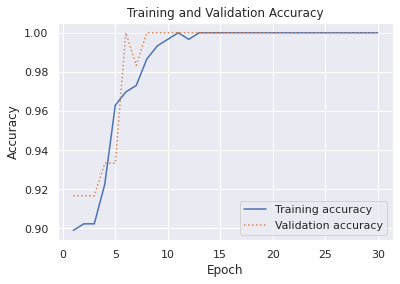

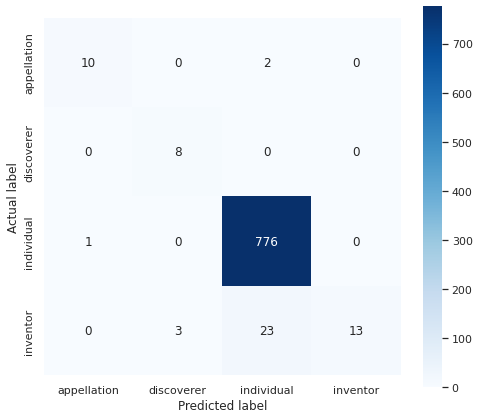

In [ ]:
# ['individual' 'inventor' 'discoverer' 'appellation' 'group' 'other']
coarse_type='person';
fine_types=['individual','inventor','discoverer','appellation']
epoch=5
learning_rate=0.002
batch_size=22
test_size=0.20
k_fold=6
dnnFineGrained(coarse_type,fine_types,epoch,learning_rate,batch_size,test_size,k_fold)

**Organization**

59
TRAIN: [10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46] VALIDATION: [0 1 2 3 4 5 6 7 8 9]
Epoch 1/10
2/2 [==============================] - 1s 194ms/step - loss: 1.0510 - categorical_accuracy: 0.2973 - val_loss: 1.5612 - val_categorical_accuracy: 0.1000
Epoch 2/10
2/2 [==============================] - 0s 48ms/step - loss: 0.8025 - categorical_accuracy: 0.6486 - val_loss: 2.1770 - val_categorical_accuracy: 0.1000
Epoch 3/10
2/2 [==============================] - 0s 35ms/step - loss: 0.7736 - categorical_accuracy: 0.6486 - val_loss: 2.2002 - val_categorical_accuracy: 0.1000
Epoch 4/10
2/2 [==============================] - 0s 36ms/step - loss: 0.7386 - categorical_accuracy: 0.6486 - val_loss: 2.0827 - val_categorical_accuracy: 0.1000
Epoch 5/10
2/2 [==============================] - 0s 35ms/step - loss: 0.6838 - categorical_accuracy: 0.9189 - val_loss: 2.0706 - val_categorical_accuracy: 0.2000
Epoch 6/10
2/2 [===========

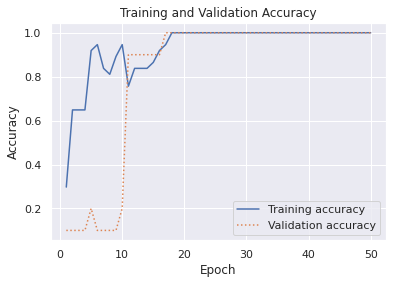

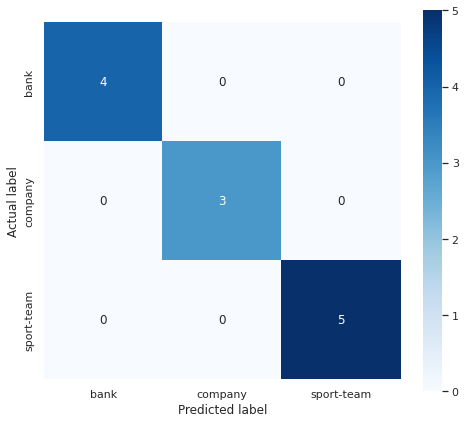

In [ ]:
coarse_type='organization';
fine_types=['sport-team','bank','company']
epoch=10
learning_rate=0.002
batch_size=22
test_size=0.20
k_fold=5
dnnFineGrained(coarse_type,fine_types,epoch,learning_rate,batch_size,test_size,k_fold)

**Location**

630
TRAIN: [  0   1   2   3 ... 495 496 500 502] VALIDATION: [ 10  14  20  24 ... 498 499 501 503]
Epoch 1/5
19/19 [==============================] - 1s 32ms/step - loss: 1.5652 - categorical_accuracy: 0.4392 - val_loss: 1.4071 - val_categorical_accuracy: 0.4356
Epoch 2/5
19/19 [==============================] - 0s 16ms/step - loss: 1.2076 - categorical_accuracy: 0.5931 - val_loss: 1.0579 - val_categorical_accuracy: 0.6733
Epoch 3/5
19/19 [==============================] - 0s 16ms/step - loss: 0.6938 - categorical_accuracy: 0.8139 - val_loss: 0.7542 - val_categorical_accuracy: 0.7723
Epoch 4/5
19/19 [==============================] - 0s 17ms/step - loss: 0.3600 - categorical_accuracy: 0.9156 - val_loss: 0.6430 - val_categorical_accuracy: 0.8218
Epoch 5/5
19/19 [==============================] - 0s 17ms/step - loss: 0.1743 - categorical_accuracy: 0.9653 - val_loss: 0.5443 - val_categorical_accuracy: 0.8020
TRAIN: [  0   3   4   5 ... 498 499 501 503] VALIDATION: [  1   2   6  11 ... 489

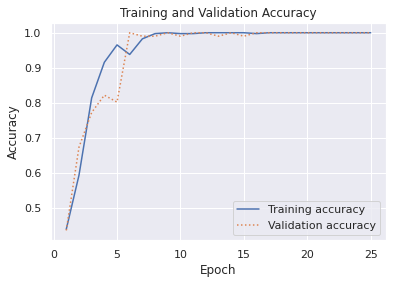

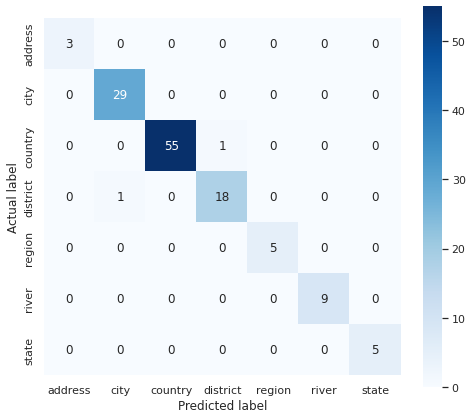

In [ ]:
coarse_type='location';
fine_types=['country','city','district','river','region','state','address']
epoch=5
learning_rate=0.003
test_size=0.20
k_fold=5
dnnFineGrained(coarse_type,fine_types,epoch,learning_rate,test_size,k_fold)

**Temporal**

525
TRAIN: [  0   1   2   3 ... 415 416 417 419] VALIDATION: [ 10  13  18  21 ... 400 408 414 418]
Epoch 1/5
16/16 [==============================] - 2s 39ms/step - loss: 1.4180 - categorical_accuracy: 0.5565 - val_loss: 1.2238 - val_categorical_accuracy: 0.5714
Epoch 2/5
16/16 [==============================] - 0s 20ms/step - loss: 1.1472 - categorical_accuracy: 0.6071 - val_loss: 0.9681 - val_categorical_accuracy: 0.6429
Epoch 3/5
16/16 [==============================] - 0s 18ms/step - loss: 0.7816 - categorical_accuracy: 0.6964 - val_loss: 0.6846 - val_categorical_accuracy: 0.7857
Epoch 4/5
16/16 [==============================] - 0s 19ms/step - loss: 0.4324 - categorical_accuracy: 0.8512 - val_loss: 0.5343 - val_categorical_accuracy: 0.8095
Epoch 5/5
16/16 [==============================] - 0s 19ms/step - loss: 0.2245 - categorical_accuracy: 0.9554 - val_loss: 0.4747 - val_categorical_accuracy: 0.8333
TRAIN: [  0   1   2   3 ... 416 417 418 419] VALIDATION: [  7  12  14  20 ... 384

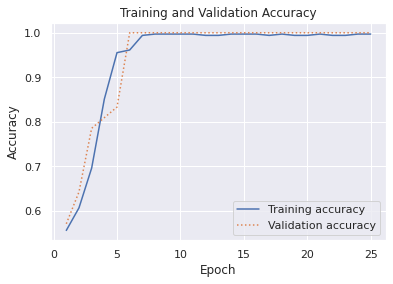

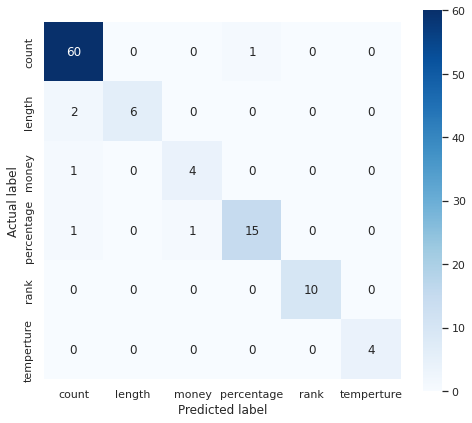

In [ ]:
coarse_type='numerical';
fine_types= ['count','percentage','rank','length','money','temperture']
epoch=5
learning_rate=0.003
test_size=0.20
k_fold=5
dnnFineGrained(coarse_type,fine_types,epoch,learning_rate,test_size,k_fold)

**Explanation**

161
TRAIN: [  0   1   2   3 ... 121 122 125 126] VALIDATION: [  6  16  19  26  38  40  45  63  64  66  80  82  89  91  94  97  98 100 108 111 113 115 119 123 124 127]
Epoch 1/5
5/5 [==============================] - 1s 100ms/step - loss: 0.6853 - categorical_accuracy: 0.6961 - val_loss: 0.9932 - val_categorical_accuracy: 0.7692
Epoch 2/5
5/5 [==============================] - 0s 25ms/step - loss: 0.4144 - categorical_accuracy: 0.8922 - val_loss: 0.7882 - val_categorical_accuracy: 0.7692
Epoch 3/5
5/5 [==============================] - 0s 30ms/step - loss: 0.3758 - categorical_accuracy: 0.8922 - val_loss: 0.6780 - val_categorical_accuracy: 0.7692
Epoch 4/5
5/5 [==============================] - 0s 25ms/step - loss: 0.3339 - categorical_accuracy: 0.8922 - val_loss: 0.6768 - val_categorical_accuracy: 0.7692
Epoch 5/5
5/5 [==============================] - 0s 26ms/step - loss: 0.2494 - categorical_accuracy: 0.8922 - val_loss: 0.6053 - val_categorical_accuracy: 0.7692
TRAIN: [  0   1   2   

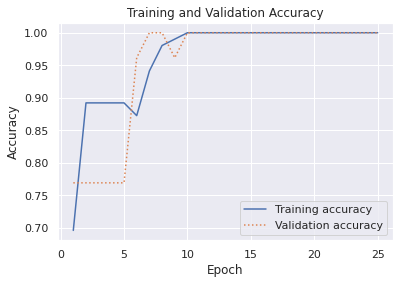

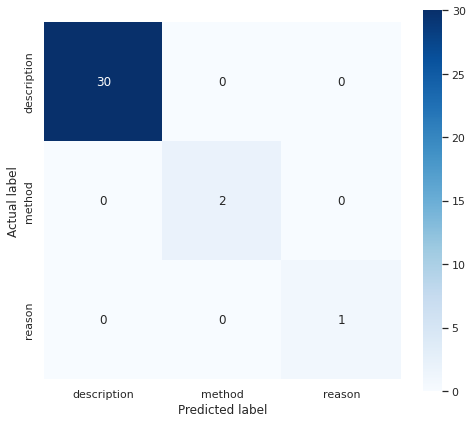

In [ ]:
coarse_type='explanation';
fine_types= ['description','method','reason']
epoch=5
learning_rate=0.003
test_size=0.20
k_fold=5
dnnFineGrained(coarse_type,fine_types,epoch,learning_rate,test_size,k_fold)

**Miscellaneous**

222
TRAIN: [  0   2   3   4 ... 173 174 175 176] VALIDATION: [  1   6  15  20  28  32  67  79  84  89  90  93  94 108 109 114 117 118 122 125 129 130 131 133 134 135 137 140 142
 147 151 153 157 158 163 168]
Epoch 1/5
7/7 [==============================] - 1s 68ms/step - loss: 2.0568 - categorical_accuracy: 0.3475 - val_loss: 2.2816 - val_categorical_accuracy: 0.2500
Epoch 2/5
7/7 [==============================] - 0s 25ms/step - loss: 1.7095 - categorical_accuracy: 0.4255 - val_loss: 1.9375 - val_categorical_accuracy: 0.3611
Epoch 3/5
7/7 [==============================] - 0s 24ms/step - loss: 1.2598 - categorical_accuracy: 0.6028 - val_loss: 1.8023 - val_categorical_accuracy: 0.4167
Epoch 4/5
7/7 [==============================] - 0s 22ms/step - loss: 0.7705 - categorical_accuracy: 0.7376 - val_loss: 1.5961 - val_categorical_accuracy: 0.5000
Epoch 5/5
7/7 [==============================] - 0s 26ms/step - loss: 0.4087 - categorical_accuracy: 0.9149 - val_loss: 1.3576 - val_categorical

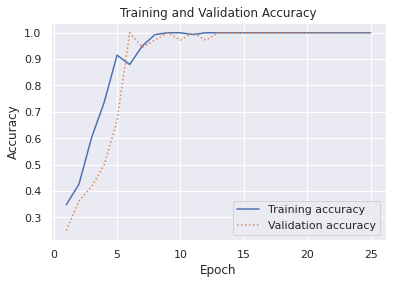

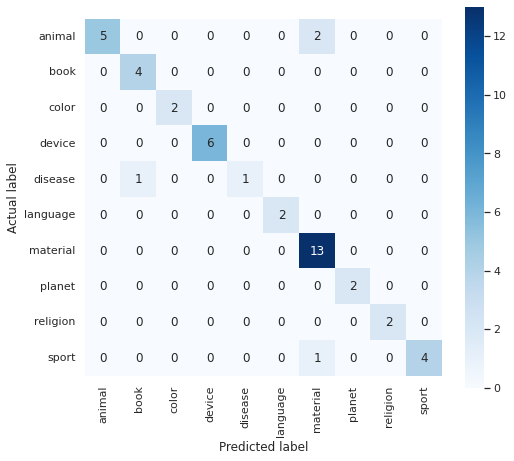

In [ ]:
coarse_type='miscellaneous';
fine_types= ['material','animal','device','sport','book','planet','color','religion','disease','language']
epoch=5
learning_rate=0.007
test_size=0.20
k_fold=5
dnnFineGrained(coarse_type,fine_types,epoch,learning_rate,test_size,k_fold)